<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 3: Practical - Variational Autoencoder (VAE) <br>
<font color=696880 size=4>
    Mahdi Manouchehry (mahdimanouchehry14@gmail.com) <br>
    
____


### Full Name : Javad Razi
### Student Number : 401204354
__

In this [link](https://lilianweng.github.io/posts/2018-08-12-vae/), you can find out more about autoencoders in general and a good explanation about variational autoencoders as well, known as VAEs.

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 


#Add Additional libraries here
import numpy as np

torch.manual_seed(42)

The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing various image processing and machine learning models. It contains 60,000 training images and 10,000 testing images of size (28, 28) and their corresponding labels from 0 to 9.

In [2]:
# Load the MNIST dataset
data = datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor())
IMAEG_DOTS = 28*28

# Data Visualization

Show 3 random samples from the dataset.

*hint: you can use "cv2" library for reading images but any other method is acceptable.*

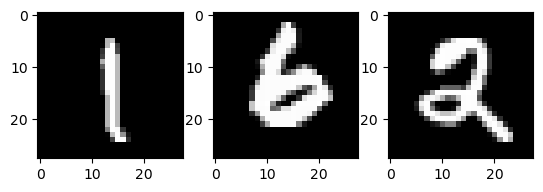

In [3]:
#################### Problem 01  ####################
fig, axs = plt.subplots(1, 3)
for ax in axs:
    img = data[np.random.randint(len(data))][0]
    ax.imshow(img.squeeze().numpy(), cmap='gray')
plt.show()


This code defines a VAE class for a variational autoencoder (VAE) model, a generative model with an encoder-decoder based structure. The encoder compresses an input to a latent vector, which is drawn from a distribution learned by the encoder outputs. The decoder reconstructs the input from the latent vector, and the model optimizes the reconstruction quality and the difference between the latent distribution and a prior distribution. A VAE class usually specifies the encoder and decoder networks, the sampling layer, and the loss function.

# Complete the following class to define the VAE structure.

In [4]:
# Define the VAE architecture
class VAE(nn.Module):
    
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        
        #################### Problem 02 - 03 ####################
        
        # Assign the dimensions of the hidden layer and the latent space
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
    
        # Deifne Encoder layers: map the input data to the mean and log variance of the latent space
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # Define Decoder layers: map the latent space to the reconstructed output data
        # Your Code

        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        
        

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu, logvar = self.fc21(h1), self.fc22(h1)
        return mu, logvar

    
    
    
    def reparameterize(self, mu, logvar):
        #################### Problem 05  ####################
        '''
        # 1. Compute the standard deviation from the log variance
        # 2. Sample a random tensor from the standard normal distribution with the same shape as std
        # 3. return a sample from the latent space using the reparameterization trick
        '''
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std # Return a sample from the latent space using the reparameterization trick
        
    
    
    def decode(self, z):
        #################### Problem 06  ####################
        '''
         Decode the latent space to the output space through:
         1. Apply a linear transformation and a ReLU activation to the latent space
         2. Apply a linear transformation and a sigmoid activation to the hidden layer
        '''
    
        h3 = nn.functional.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
           
    
    
    def forward(self, x):
        #################### Problem 07  ####################
        '''
        The forward propagation of your model:
        1. Encode the input data and get the mean and log variance of the latent space
        2. Reparameterize the mean and log variance and get a sample from the latent space
        3. Return the decoded samples, mu and logvar
        '''
        
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar  # return results
        

# Define the Loss Function
Compute the binary cross entropy between the reconstructed data and the original data.

Also, you need to compute the KL divergence between the distribution of the latent space and a standard normal distribution.

The total loss would be the sum of these two losses.

In [5]:
def loss_function(recon_x, x, mu, logvar):
    #################### Problem 08  ####################
    '''
    Compute the binary cross entropy between the reconstructed data and the original data
    Compute the KL divergence between the Gaussian distribution of the latent space and a standard normal distribution
    '''
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, IMAEG_DOTS), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # Return the sum of binary cross entropy and KL divergence as the total loss

# Training the Model

Here we have provided a function which trains the model using the specified input arguments. (Make sure to understand the code!)

In [6]:
def train(model, optimizer, train_loader, device, epoch_no):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch_no, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

In [8]:
#################### Problem 09  ####################
  # Set the batch size for loading the data
####################################################
batch_size = 128


#################### Problem 10  ####################
# Create a data loader object that shuffles and batches the data
####################################################
train_loader = DataLoader(data, batch_size=batch_size, shuffle=True)


#Choose the device (CPU or GPU) based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Create an instance of the VAE model and move it to the device
model = VAE(input_size=IMAEG_DOTS, hidden_size=512, latent_size=24).to(device)


#################### Problem 11  ####################
#Create an instance of the Adam optimizer with a learning rate(try different learning rate)
#Set the number of epochs to train the model 
####################################################
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50
loss_values = []

for epoch in range(1, epochs+1):
    avg_loss = train(model, optimizer, train_loader, device, epoch)
    loss_values.append(avg_loss)
    
    



====> Epoch: 1 Average loss: 161.1906
====> Epoch: 2 Average loss: 119.8250
====> Epoch: 3 Average loss: 113.2946
====> Epoch: 4 Average loss: 110.4774
====> Epoch: 5 Average loss: 108.8470
====> Epoch: 6 Average loss: 107.7495
====> Epoch: 7 Average loss: 107.0217
====> Epoch: 8 Average loss: 106.3962
====> Epoch: 9 Average loss: 105.9035
====> Epoch: 10 Average loss: 105.5399
====> Epoch: 11 Average loss: 105.1918
====> Epoch: 12 Average loss: 104.9737
====> Epoch: 13 Average loss: 104.6832
====> Epoch: 14 Average loss: 104.4223
====> Epoch: 15 Average loss: 104.2577
====> Epoch: 16 Average loss: 104.0491
====> Epoch: 17 Average loss: 103.9034
====> Epoch: 18 Average loss: 103.7011
====> Epoch: 19 Average loss: 103.5727
====> Epoch: 20 Average loss: 103.4239
====> Epoch: 21 Average loss: 103.2873
====> Epoch: 22 Average loss: 103.1595
====> Epoch: 23 Average loss: 103.0916
====> Epoch: 24 Average loss: 102.9689
====> Epoch: 25 Average loss: 102.9361
====> Epoch: 26 Average loss: 102.

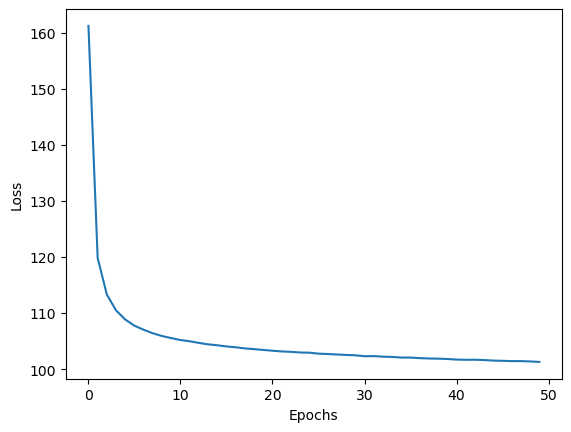

In [9]:
# Plotting the loss values for each epoch
plt.plot(loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Generative Model
Now that you have trained your model, you can generate new images by sampling from the latent space and decoding them as below: (make sure to understand how the code works!)

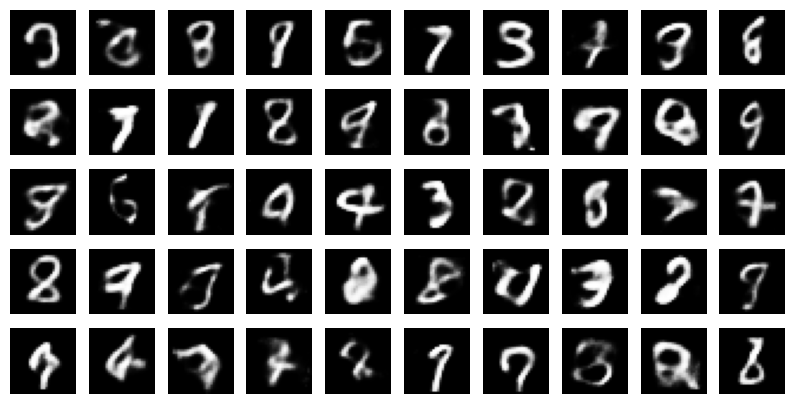

In [11]:
with torch.no_grad():
    z = torch.randn(batch_size, 24).to(device)
    sample = model.decode(z).cpu()
    
    # Plot the generated images
    fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(10,5))
    for i in range(5):
        for j in range(10):
            ax[i][j].imshow(sample[i*10+j].reshape(28, 28), cmap='gray')
            ax[i][j].axis('off')
    plt.show()